# Estimating the CMB Power Spectrum

In [1]:
import numpy as np
import sys
import astropy.io.fits as fits

#Plotting Modules
import matplotlib as mpl
from matplotlib import cm as cm, mlab as mlab, pyplot as plt

#Plotting Settings
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.figsize'] = [8, 6]

#Files in this Repo
import constants as cs # the constants module
from cmb_modules import * # the module of functions

## Creating a Realistic CMB Simulation

The following cell contains values for parameters for the realistic CMB simulation.

In [2]:
N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp  # arcmin

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level    # microK - arcmin
atmospheric_noise_level = cs.atmospheric_noise_level    # microK - arcmi
one_over_f_noise_level = cs.one_over_f_noise_level    # microK - arcmi

The following cell creates a realistic simulation of the CMB.

Since the power spectrum is a function of $\ell$ we need to do much of the work in harmonic space.  If we were generating a map on the full sky, we would need to work with spherical harmonics.  Here we consider a small patch of sky ($\sim 8.5^\circ \times 8.5^\circ$) were we can use the 'flat-sky' approximation and replace $\ell$ with $k = \sqrt{k_x^2 + k_y^2}$.  There is a linear dependance between these variables defined by $\ell = k* 2 \pi = 2 \pi / \theta$.

The steps are as follows:

1. Create a signal-only CMB map

    a. Convert a 1D CMB power spectrum to 2D by revolving it about the axis in polar coordinates.
    
    b. Randomly sample each point in harmonic space from a Gaussian with zero mean and variance given by the 2D power spectrum.

    c. Convert to real space.

1. Generate astrophysical foreground maps (point sources and tSZ clusters) by sampling their distributions at each point in real space. Add these to the CMB map. 

1. Convolve map with beam. 

1. Add white noise and atmospheric noise.

To see how this is done, you can look at the code for their corresponding functions. Understanding this is not necessary for the remainder of the notebook.

map mean: -9.050940150211064 map rms: 97.31186051005592


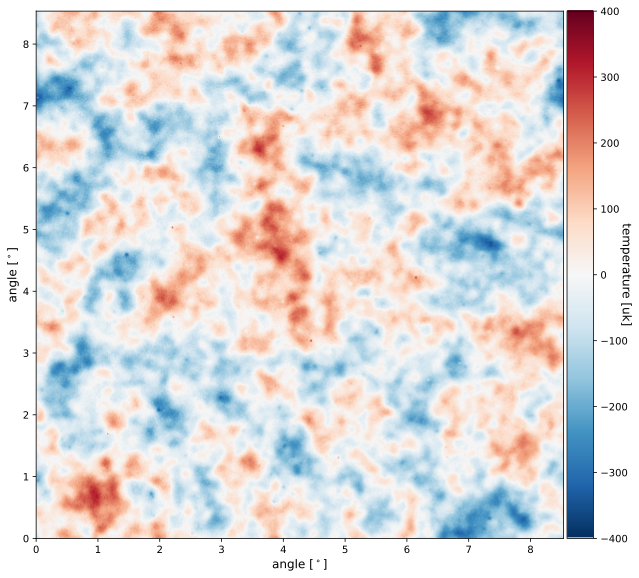

In [23]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T  + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
p=Plot_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

<font color='red'>EXCERCISE: </font>  There are three typical beam sizes for CMB experiments: 

1) large anguar scale B-mode observatories, which have ~30 arcminute beams; 

2) medium scale observatories, such as the Planck satellite that has a ~3 arcminute beam; and 

3) high resolution observatories, such as ACT and SPT that have ~1 arcminute beams.

Convolve your map with each of these cases and compare the differences. You can turn off the noise to isolate the effect of the beam.

In [26]:
## your code goes here

Your comments go here

<font color='red'>EXCERCISE: </font>  The white noise levels for several CMB experiments are listed below.

| Survey | White Noise ($\mu K-\text{arcmin}$) |
| :----: | :---------------------------: |
| Planck |              25               |
|  ACT   |           ~13 - 15            |
|   SO   |               6               |
|   S4   |               1               |

Adjust the white noise level and see how the map changes. 

In [27]:
## your code goes here

Your comments go here

## Processing the Map

### Apodize  the map to eliminate edge effects

Before taking a 2d FFT (eg the obvious thing to do for computing a power spectrum) we must apodize the maps to eliminate edges effects.  Edge effects come about because the Fourier transform treats a square array as having periodic boundaries.  Thus if we take the Fourier transform of a 2-dimensional map and the values on the left and right side (and also, top and bottom) of the map don't match, we end up generating spurious signals.   In this example we use a cosine window to smoothly roll off the signal to zero as we approach the edges of the map.  There are many choices of windows that trade sensitivity loss, coupling of adjacent modes, and ringing.

map mean: 0.7824137564111536 map rms: 53.19571505727186


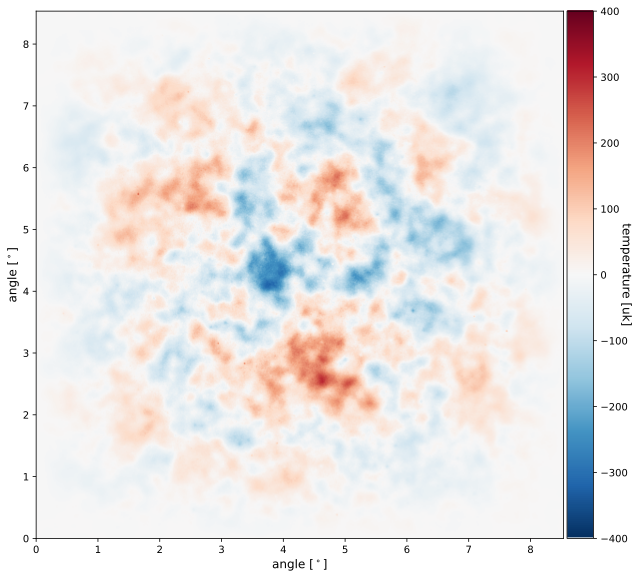

In [6]:
def cosine_window(N):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system
    N=int(N) 
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.)/N *np.pi ## eg runs from -pi/2 to pi/2
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)
  ###############################
    
window = (cosine_window(N))
    
appodized_map = window * total_map_plus_noise

p=Plot_Map(appodized_map,c_min,c_max,X_width,Y_width)

This shows our simulated map with a cosine window applied to eliminate edge effects.  It is obvious from this map that we are suppressing the signal here.

## Measuring the Power Spectrum

### Naive Powerspectrum

Here we compute a naive power spectrum and compare it to the input power spectrum for our simulations.  The power spectrum is computed by: (1) applying a 2d FFT, (2) taking the absolute value squared of this map in Fourier space ($k_x$ and $k_y$), and (3) averaging the signal in annular bins of $k = \sqrt{k_x^2 + k_y^2}$.  These bins are converted to bins in $\ell$ with the scaling: $\ell = k* 2 \pi$ per the flat sky approximation. 

In [7]:
#### parameters for setting up the spectrum
delta_ell = 50.
ell_max = 5000.

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

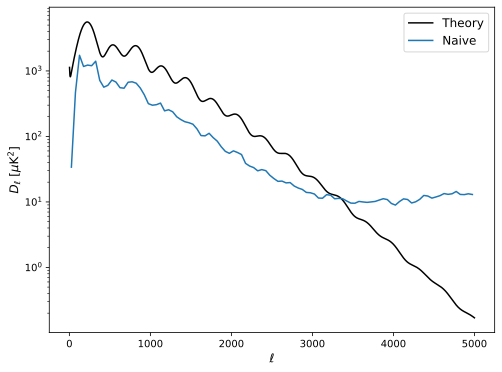

In [24]:
## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
#print binned_ell

#Plot
plt.semilogy(ell,DlTT, color='black', label= 'Theory')
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi, label= 'Naive')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

This plot shows the input CMB power spectrum and the naive power spectrum we estimated from our CMB map.  The naive spectrum does not match the input due to a combination of: instrumental noise, SZ and point source signals; and suppression from the beam and the apodization.   

<font color='red'>EXCERCISE: </font>  Generate the power spectrum with only the beam convolved CMB (no astrophysical foregrounds) and compare it to our naive power spectrum above (remember to apodize it!). What scales do the foregrounds affect and why?

In [28]:
## your code goes here

Your comments go here

<font color='red'>EXCERCISE: </font>  Vary the beam and white noise levels corresponding to different CMB surveys. How do these affect the power spectrum?

In [29]:
## your code goes here

Your comments go here

### Correcting the biases in the naive power spectrum

To correct the naive spectrum and obtain an unbiased estimate of the underlying power spectrum in our simulated map we must correct additive bias and multiplicative bias.   We can relate our measured spectrum $\hat D_\ell$ to the true underlying spectrum $D_\ell$ as follows:

$$\hat D_\ell = T*D_\ell + N. $$

Here $N$ represents an additive noise term and $T$ represents a transfer function of the instrument (beam) and filtering (in this case the apodization, but other processing can enter, for example a 1-d high pass filter to eliminate striping).   All of these terms are functions of $\ell$.

The true power spectrum can be recovered by using monte carlo technqies.  To apply this technique we use simulations to calibrate $T$ and $N$ and then use algebra to correct the naive measurement.  This is compactly expressed in the following equation:

$$ D_\ell = (\hat D_\ell - N)/T. $$

In the next two sections we use simulations to calibrate $T$ and $N$ to recover an unbiased estimate of the underlying power spectrum.  Subsequently we will used monte carlo simulations to estimate the error bars on this measurement and compare to theoretical Gaussian error bars.

### Calibrating the transfer function

The transfer function can be calibrated by: (1) generating sky simulations with a known power spectrum, modeling the transfer function of the instrument and the post-processing, and keeping the noise level to zero,; and (2) calculating the naive power spectrum from each simulation, (3) running many simulations to reduce numerical noise, and (4) dividing the true spectrum by the the average signal only spectrum to recover our estimate for the transfer function. This is shown in the following equation:

$$ \frac{D_\ell}{\langle \hat D_\ell \rangle} = T $$

The accuracy depends on the number of realizations used.  Here  we used 64 realizations as a compromise between speed and accuracy.  

Here we use a CMB only spectrum to estimate the transfer function.  We could improve the estimate of the transfer function by using an input power spectrum that is modified to follow the effect of point sources. 

 signal only sims, iterations complete: 64 of 64

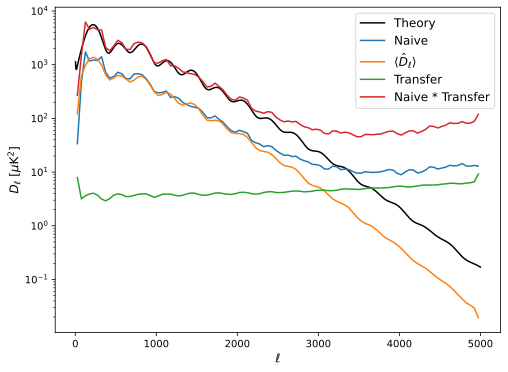

In [12]:
N_iterations = 64

signal_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = make_map(N,pix_size,ell,DlTT)
    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(CMB_T_convolved*window,CMB_T_convolved*window,delta_ell,ell_max,pix_size,N)
    signal_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

def average_N_spectra(spectra,N_spectra,N_ells):
    avgSpectra = np.zeros(N_ells)
    rmsSpectra = np.zeros(N_ells)
    
    # calculate the average spectrum
    avgSpectra = np.mean(spectra, axis= 0)
    
    #calculate the rms of the spectrum
    rmsSpectra = np.sqrt( np.mean( (spectra - avgSpectra)**2 , axis=0) )

    return(avgSpectra,rmsSpectra)


sig_only_mean_spectrum, rms_not_needed = average_N_spectra(signal_only,N_iterations,int(ell_max/delta_ell))
    
sub_sampled_CLs = DlTT[binned_ell] * 2. * np.pi / (binned_ell * (binned_ell+1.))

Multiplicative_Bias_est =  sub_sampled_CLs / sig_only_mean_spectrum
   
## make some plots
plt.clf()
plt.semilogy(ell,DlTT,
             color='black', 
             label= 'Theory')
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,
             label= 'Naive')
plt.semilogy(binned_ell,(sig_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,
             label= r'$\langle \hat D_\ell \rangle$')
plt.semilogy(binned_ell,(Multiplicative_Bias_est),
             label= 'Transfer')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,
             label= 'Naive * Transfer')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

This plot shows the estimate of the CMB power spectrum after correcting for the multiplicative bias (transfer function).   In addition we show the input CMB power spectrum, the naive power spectrum of our map, the average of the signal only simulations, and the transfer function.  Consider how all these curves relate to creating the yellow estimate.

### Calibrating the noise bias

The noise bias can be computed by running noise only simulations through the naive power spectrum estimator and computing the average power spectrum.

NOTE: An alternative approach exists for dealing with the noise.  If you can subdivide your data into subsets with common signal but independent noise, one can compute "cross-spectra" between these subsets.  (You compute these by doing a 2d FFT on each subset and then multiplying one by the complex conjugate of the other.)   This results in some information loss (since you are throwing out the auto-correlation of each subset, but it completely eliminates potential measurement bias from an incorrect noise model.  

As a two part exercise: (1) use the wrong noise model in analyzing the power spectrum to see what happens, and (2) implement a cross-spectrum estimator to see that this noise bias goes away with cross spectra.  Also note that the error bars grow with the cross spectrum. 

 noise only sims, iterations complete: 64 of 64

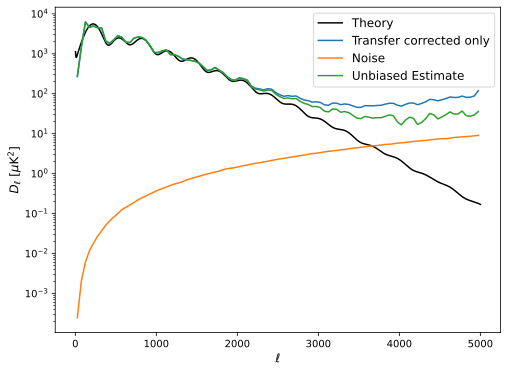

In [13]:
noise_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(Noise*window,Noise*window,delta_ell,ell_max,pix_size,N)
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r noise only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum, rms_not_needed = average_N_spectra(noise_only,N_iterations,int(ell_max/delta_ell))

Additive_Bias_est = noise_only_mean_spectrum


#plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
#plt.semilogy(binned_ell,(sig_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
#plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b')
plt.semilogy(ell,
             DlTT,
             color='black', 
             label= 'Theory')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est*\
             binned_ell * (binned_ell+1.)/2. / np.pi,
             label= 'Transfer corrected only')
plt.semilogy(binned_ell,(noise_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,
             label= 'Noise')
plt.semilogy(binned_ell,(binned_spectrum -noise_only_mean_spectrum)\
             *Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,
             label= 'Unbiased Estimate')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

The green curve in this plot shows our unbiased estimate for the spectrum.  This estimate includes corrections for the noise bias and the transfer function.  Also shown is our estimate for the noise only additive bias, the spectrum accounting for only the multiplicative bias as was done above, and the underlying power spectrum used in generating our simulated map.

At this point we have an unbiased estimate of the power spectrum. Note that at high-$\ell$  the spectrum is dominated by the SZ and point source components. 

## Quantifying Error Bars

### Theoretical Error Bars

To get an initial estimate for the uncertainty on our power spectrum, we start with the gaussian covariance of our power spectrum. To do so, we use the so-called "Knox Formula":
$$
\sigma^2(C_\ell^{AB}) = \frac{1}{(2\ell+1)f_{\rm sky} \Delta_\ell} \left( C_\ell^{AA} C_\ell^{BB} + (C_\ell^{AB})^2 \right)
$$
Here, $A$ and $B$ are the two fields being cross-correlated, with $AB$ labeling the cross-power spectrum and $AA$ and $BB$ the auto-power spectra, and $f_{\rm sky}$ is the sky fraction used for the measurement.  We assume that the power spectra have been measured in multipole bins of width $\Delta_{\ell}$.

For an autospectrum, the error bars simplify to 
$$
\sigma(C_\ell^{AA}) = C_\ell^{AA} \sqrt{ \frac{2}{(2\ell+1)f_{\rm sky} \Delta_\ell} }
$$


In the cell below, complete the Knox formula function. Then use it to plot out our unbiased spectrum with these theoretical error bars using our estimated autospectrum as input.

In [30]:
def calculate_fsky(N, pix_size):
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    area_in_rad = (N * pix_to_rad)**2
    fsky = area_in_rad / 4 / np.pi

    return fsky

def knox_errors(ells:"1d array of len Nells",
                Cl:"1d array of len Nells",
                fsky:"float",
                binsize:"int"
                ):
    # Fill me in!

IndentationError: expected an indented block (4277343695.py, line 13)

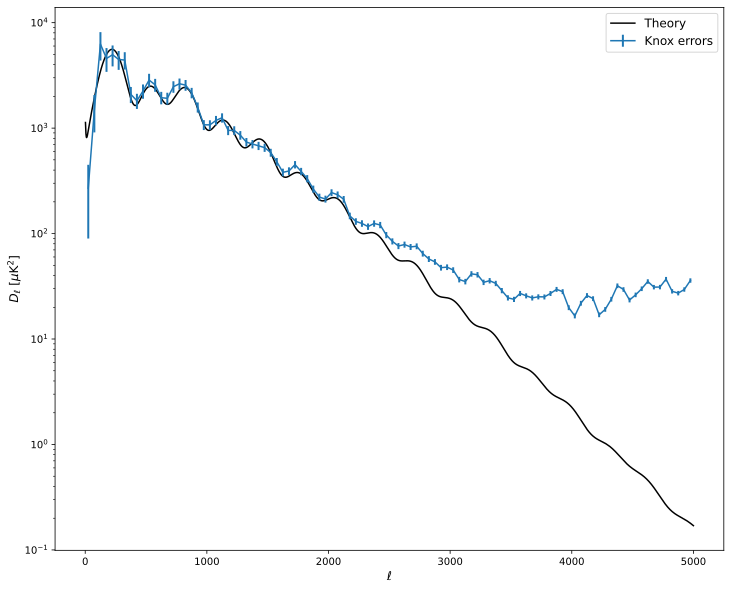

In [15]:
Cl_unbiased = (binned_spectrum - noise_only_mean_spectrum)*Multiplicative_Bias_est

#Calculate Knox Error Bars
fsky = calculate_fsky(N, pix_size)
knox_err = knox_errors(binned_ell, Cl_unbiased, fsky, delta_ell)

#Plotting
plt.clf()
plt.gcf().set_size_inches(12, 10)
plt.semilogy(ell,DlTT,
             color='black',
             label='Theory')
plt.errorbar(binned_ell, Cl_unbiased* \
             binned_ell * (binned_ell+1.)/2. / np.pi, \
             yerr=knox_err * binned_ell * (binned_ell+1.)/2. / np.pi,\
             elinewidth=2,
             label= 'Knox errors')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.legend()
plt.xlabel('$\ell$')
plt.show()


<font color='red'>EXCERCISE: </font> We used our estimated power spectrum for these error bars. We also could've used our theoretical power spectrum. Is one better than the other?


Your comments go here

### Simulation-based Error Bars


These error bars are computed by generating simulations including signal and noise, computing the naive power spectrum, taking the RMS of these results and then subtracting the noise bias and accounting for the transfer function.  In effect we are simulating running the experiment a bunch of times and looking at the RMS of the results--- this approach is broadly applicable to other problems.

 signal and noise sims, iterations complete: 64 of 64

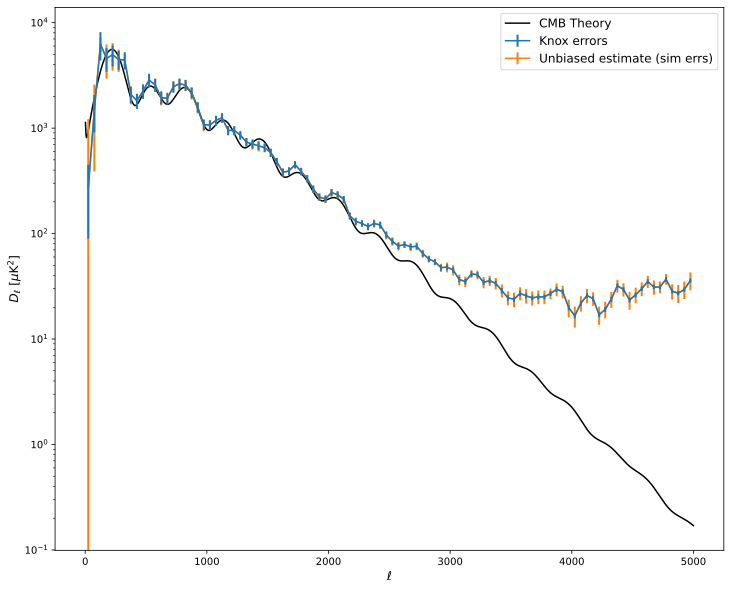

In [16]:
SplusN  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = make_map(N,pix_size,ell,DlTT)

    PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
    PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)
    SZMap,trash = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,\
                                      Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)
    
    CMB_T  = CMB_T + PSMap + SZMap

    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum((CMB_T_convolved+Noise)*window\
                                                                ,(CMB_T_convolved+Noise)*window\
                                                                ,delta_ell,ell_max,pix_size,N)
    SplusN[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal and noise sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    #p=Plot_CMB_Map(CMB_T_convolved+Noise,c_min,c_max,X_width,Y_width)
    i = i + 1
    
mean_not_needed,rms_sig_plus_noise = average_N_spectra(SplusN,N_iterations,int(ell_max/delta_ell))

Cl_unbiased = (binned_spectrum - noise_only_mean_spectrum) * Multiplicative_Bias_est

plt.clf()
plt.gcf().set_size_inches(12, 10)
plt.semilogy(ell,DlTT, 
             color='black', 
             label='CMB Theory')
plt.errorbar(binned_ell, Cl_unbiased* \
             binned_ell * (binned_ell+1.)/2. / np.pi, \
             yerr=knox_err * binned_ell * (binned_ell+1.)/2. / np.pi,\
             elinewidth=2,
             label= 'Knox errors',
             zorder= 3)
plt.errorbar(binned_ell, Cl_unbiased* \
             binned_ell * (binned_ell+1.)/2. / np.pi,
             yerr=rms_sig_plus_noise*Multiplicative_Bias_est * binned_ell * (binned_ell+1.)/2. / np.pi,
             elinewidth=2,
             label= 'Unbiased estimate (sim errs)',
             zorder= 2)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

<font color='red'>EXCERCISE: </font> Compare the sim-based error bars to the Knox formula expectation by plotting their ratio. Do they agree at high $\ell$? Should they? 


In [32]:
# your code goes here

Your comments and discussion go here

<font color='red'>EXCERCISE: </font> Which is better: knox or sim errors?

Your comments and discussion go here

And there you have it.  That is how you compute a CMB power spectrum and error bars.   If you want to fit cosmology to these data, you can run CAMB varying cosmological parameters and compute the likelihood difference between these models and the data.  
